In [1]:
import math
import nltk
import unicodedata
import time
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dt
from matplotlib.dates import DateFormatter

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import models as md
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
company = "TSLA"

In [4]:
all_stocks = pd.read_csv("stock_yfinance_data.csv")
stock_df = all_stocks[all_stocks['Stock Name'] == company]
stock_df = stock_df.drop('Stock Name', axis=1)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df = stock_df.set_index("Date")
stock_df.dropna()

processed_df = pd.read_csv('tweet_processed_labeled.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Date'] = processed_df['Date'].dt.date
daily_sentiments_df = processed_df.groupby([processed_df['Date']]).mean(numeric_only=True)

dataset_df = stock_df.copy()
dataset_df = dataset_df.join(daily_sentiments_df, how="left", on="Date")
dataset_df

,Open,High,Low,Close,Adj Close,Volume,Negative,Neutral,Positive,Compound
Date,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.081300,0.739611,0.179067,0.241496
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.051798,0.811106,0.137106,0.198523
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.057303,0.821563,0.121118,0.100760
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.076352,0.796693,0.126989,0.112765
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.054769,0.771756,0.173500,0.213876
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.073233,0.792605,0.134128,0.124760
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.081292,0.765111,0.153556,0.130479
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.059835,0.796282,0.143882,0.178928


In [5]:
def SplitData(data, train_size, timestep):
    data_values = data.values
    training_data_len = math.ceil(len(data)* train_size)

    scaler = MinMaxScaler(feature_range=(0,1))
    if (len(data_values.shape) == 1):
        scaled_data = scaler.fit_transform(data_values.reshape(-1,1))
    else:
        scaled_data = scaler.fit_transform(data_values)
        scaled_index = scaler.fit_transform(data_values[:, 0:1].flatten().reshape(-1,1))

    train_data = scaled_data[0: training_data_len, :]
    test_data = scaled_data[training_data_len-timestep: , :]

    train_data_x = train_data[0: training_data_len, :]
    train_data_y = train_data[0: training_data_len, 0:1]

    x_train = []
    y_train = []

    for i in range(timestep, len(train_data_x)):
        x_train.append(train_data_x[i-timestep:i])
        y_train.append(train_data_y[i][0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    test_data = scaled_data[training_data_len-timestep: , : ]
    x_test = []
    if (len(data_values.shape) == 1):
        y_test = data_values[training_data_len:]
    else:
        y_test = data_values[training_data_len: , 0]

    for i in range(timestep, len(test_data)):
        x_test.append(test_data[i-timestep:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return x_train, y_train, x_test, y_test, scaler

In [6]:
def TrainModel(x_data, y_data, epoch, neuron_units):

    regressor = Sequential()
    regressor.add(LSTM(units=neuron_units, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=neuron_units, return_sequences=False))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, verbose=0, validation_split=0.2)

    return regressor, history

In [7]:
single_data = dataset_df['Close']
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [8]:
model_mode = ['single', 'combined']

comparison_training_history = []
comparison_test_data = []

c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\laragon\bin\python\python-3.10\lib\site-packages\ker

c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


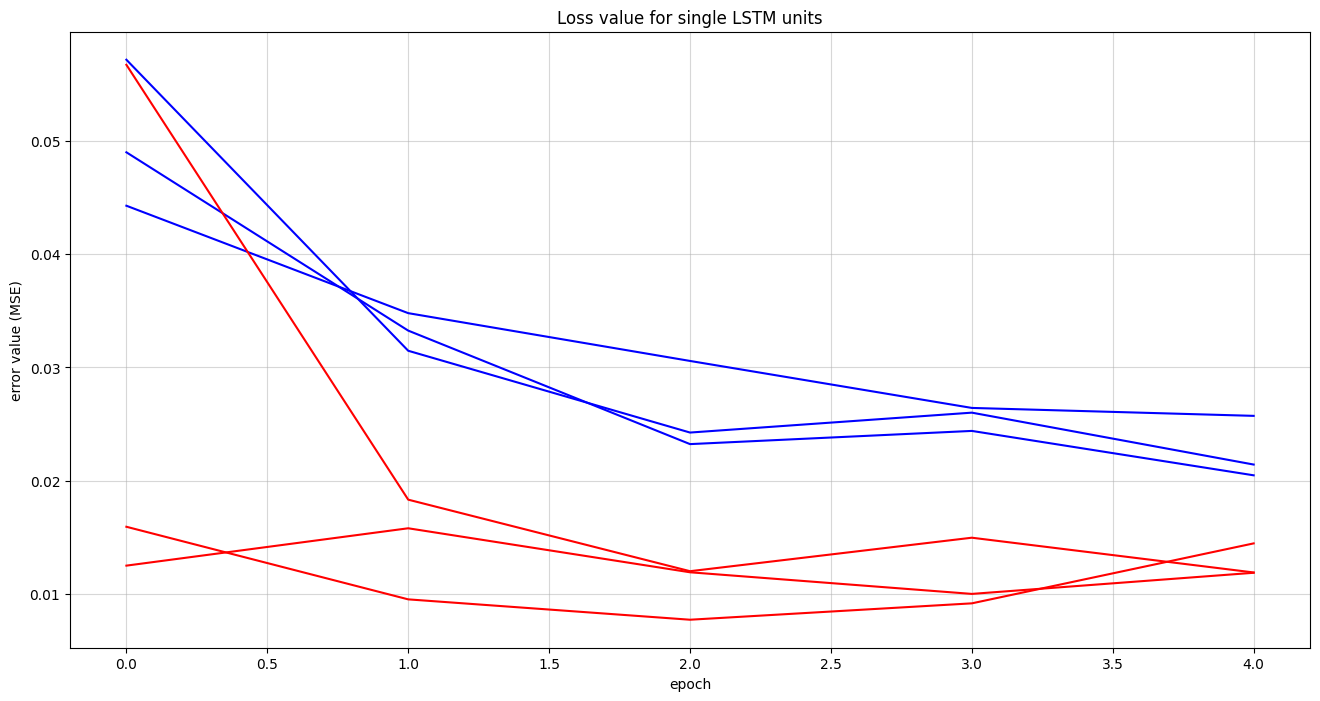

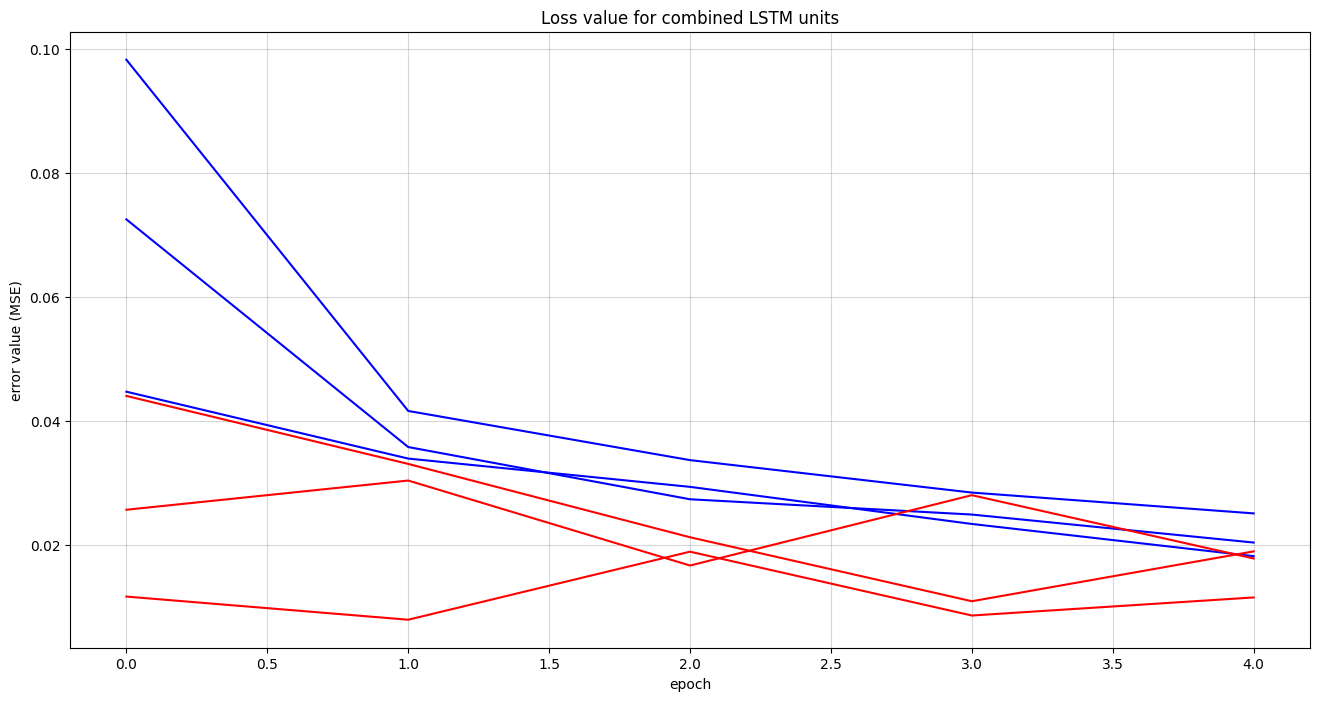

In [9]:
for i in range(len(model_mode)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(model_mode[i]) + ' LSTM units')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error value (MSE)')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for k in range(3):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModel(x_train, y_train, 5, 16)
        end_time = time.time()
        training_time = end_time - start_time

        sentimentModel.save('compare_data/saved_model/'+ str(model_mode[i]) + '_' + str(k) +'.h5')

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        comparison_training_history.append([model_mode[i], k, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])


        predictions = sentimentModel.predict(x_test, verbose=0)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        comparison_test_data.append([model_mode[i], k, mae, mse, rmse, mape, training_time])


        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('compare_data/'+ str(model_mode[i]) +'model', facecolor=(1, 1, 1))

In [10]:
training_comparison = pd.DataFrame(comparison_training_history, columns=['#mode', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
training_comparison.to_csv('compare_data/finetuning_training_data.csv', index=False)

In [11]:
testing_comparison = pd.DataFrame(comparison_test_data, columns=['#mode', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
testing_comparison.to_csv('compare_data/finetuning_testing_data.csv', index=False)